## 7.7 使用tf.keras构建神经网络
Keras 是一个主要由 Python 语言开发的开源神经网络计算库，最初由 François Chollet 编写，它被设计为高度模块化和易扩展的高层神经网络接口，使得用户可以不需要过多的专业知识就可以简洁、快速地完成模型的搭建与训练。Keras 库分为前端和后端，其中后端可以基于现有的深度学习架构实现，如TensorFlow、Theano、CNTK等。
TensorFlow 与 Keras 存在既竞争又合作的关系，甚至连 Keras 创始人都在Google 工作。早在2015年11月，TensorFlow被加入Keras后端支持。从2017年开始，Keras的大部分组件被整合到TensorFlow架构中。在2019年6月发布TensorFlow 2版本时，Keras 被指定为TensorFlow官方高级 API，用于快速简单的模型设计和训练。现在只能使用 Keras的接口来完成TensorFlow层方式的模型搭建与训练。在TensorFlow中，Keras被实现在tf.keras模块中。下文如无特别说明，Keras均指代tf.keras实现，而不是以往的 Keras实现。

### 7.7.1 tf.kera概述
	在TensorFlow 2.0及以上版本中，tf.Keras是一个用于构建和训练深度学习模型的高阶 API。tf.Keras由模块（Module）、类（Class)和函数（Function）三部分构成。
	Module中有构建训练模型各种必备的组件，如激活函数activations、网络层、损失函数losses、优化器optimizers等。
Class中有Sequential和Model两个类，它们用来堆叠模型，其中：
- class Model：将层分组为具有训练和推理功能的对象。
- class Sequential: 将layers进行线性堆叠形成一个tf.keras.Model对象。  
Function中有Input()函数，它用来实例化张量。

### 7.7.2 tf.keras的常用模块
	tf.keras中的模块几乎涵盖构建训练模型时各种必备的组件，表7-2为tf.keras的常用模块及对应功能简介。

|表7-2 tf.keras常用模块及对应功能简介 |
|-------------------------------------|

|主要模块	|功能概述|
|:----------|:------------------------------------------------|
activations	|内置的激活函数|
applications	|预先训练权重的罐装架构Keras应用程序|
Callbacks	|在模型训练期间的某些时刻被调用的实用程序|
Constraints	|约束模块，对权重施加约束的函数|
datasets	|tf.keras数据集模块，包括boston_housing，cifar10，fashion_mnist，imdb ，mnist，reuters|
estimator	|Keras估计量API|
initializers	|初始序列化/反序列化模块|
layers	|Keras层API，包括卷积层、全连接层、池化层、Embedding层等|
losses	|内置损失函数|
metircs	|内置度量函数|
mixed_precision	|混合精度模块|
models	|模型克隆的代码，以及与模型相关的API|
optimizers	|内置的优化器模块|
preprocessing	|Keras数据的预处理模块|
regularizers	|内置的正则模块|


### 7.7.3 构建模型的几种方法
	在tf.keras的类中有Sequential和Model两个类，它们分别是用来堆叠网络层和把堆叠好的层实例化可以训练的模型。
	Sequential将layers进行线性堆叠形成一个tf.keras.Model对象，使用Sequential可按层顺序构建模型，Sequential 模型只适用于多层简单堆叠网络，不能构建复杂模型（如多个输入或输出、拼接网络层等），如果要构建复杂的网络，可以通过应用或继承tf.keras.Model类来实现。通过应用tf.keras.Model类用函数式API构建任意结构模型，通过继承Model基类用子类模型API（Model Sub-Classing API）构建网络模型。图7-35为使用tf.keras构建神经网络的3种模式的示意图。
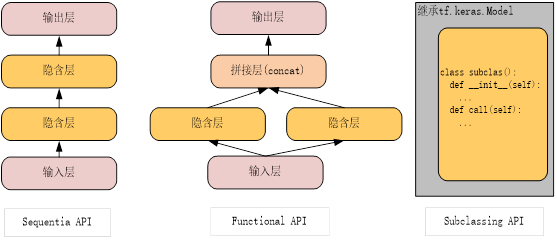
<center> 图7-35 tf.keras 构建网络的3种模式</center>

1、使用Sequential按层顺序构建模型  
通过使用tf.keras.Sequential构建模型，整个网络结构是串行的，一个输入、一个输出、中间的隐含层是串行的。简洁直观，，能满足我们大部分需求，其结构如图7-35所示。  
这是代码示例：

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss=tf.keras.losses.categorical_crossentropy,
             metrics=[tf.keras.metrics.categorical_accuracy])

2、构建函数式模型  
使用tf.keras.Model类构建函数式模型。

3、构建子类模型  
通过继承tf.keras.Model类来构建子类化模型。

### 7.7.4 使用Sequential API搭建神经网络实例
	使用Sequential API构建神经网络非常直观、简洁，输入、隐含层、输出构成一个串行结构，就像堆积木一样。这种结构虽然简单，但能满足我们大部分需求，不失为初学者的首选。
	这里我们使用数据集是Fashion MNIST，它是MNIST一个替代品，格式与MNIST完全相同（共有70000张灰度图，每张的像素是28 × 28，共有10类，训练60000张，10000张用来测试。），图的内容是日常物品，如上衣、裤子、鞋子等等，不是数字，每类中的图像更丰富，识图的挑战性比MNIST高得多。为便于大家使用，这里采用本地加载数据的方式。主要步骤如下：
- 加载数据
- 预处理数据
- 构建模型
- 训练模型
- 测试模型
- 使用回调机制保存模型
- 使用TensorBoard进行可视化运行结果  
1、加载数据  
1）先导入需要的库。

In [3]:
import os
import math
import numpy as np
import gzip
import time
import pickle as p
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

2）定义加载数据的函数。数据存放在本地，共有4个压缩文件。

In [4]:

def load_data_fromlocalpath(input_path):
  """加载数据集Fashion-MNIST dataset.
    input_path为本地目录.
    返回以下元组:
    (x_train, y_train), (x_test, y_test).
  """
  files = [
      'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
      't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
  ]

  paths = []
  for fname in files:
    paths.append(os.path.join(input_path, fname))  # The location of the dataset.

  with gzip.open(paths[0], 'rb') as lbpath:
    y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[1], 'rb') as imgpath:
    x_train = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)

  with gzip.open(paths[2], 'rb') as lbpath:
    y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

  with gzip.open(paths[3], 'rb') as imgpath:
    x_test = np.frombuffer(
        imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)
  return (x_train, y_train), (x_test, y_test)

3）加载数据。

In [5]:
data_dir = r'../data/fashion-mnist'
(x_train,y_train),(x_test,y_test) = load_data_fromlocalpath(data_dir)

In [6]:
print("训练集大小:{},测试集大小：{}".format(x_train.shape,x_test.shape))

训练集大小:(60000, 28, 28),测试集大小：(10000, 28, 28)


4）随机查看10个图。

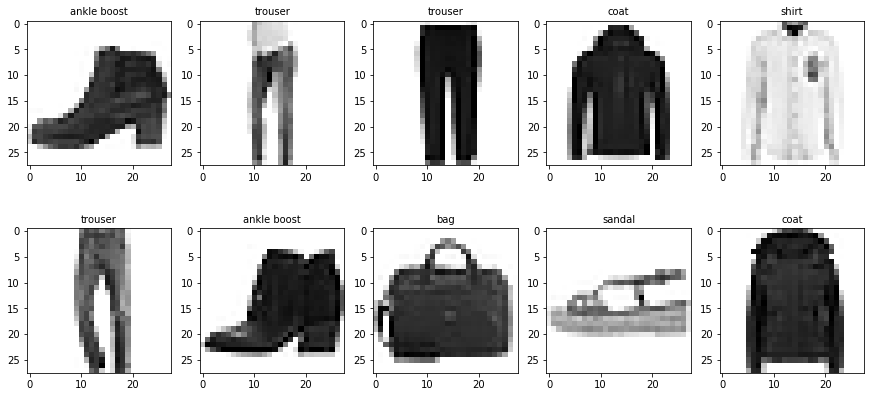

In [7]:
label_dict={0:'t-shirt',1:'trouser',2:'pullover',3:'dress',4:'coat',5:'sandal',6:'shirt',7:'sneaker',8:'bag',9:'ankle boost'}

def plot_images_labels(images, labels, num):
    total = len(images)
    fig = plt.gcf()
    fig.set_size_inches(15, math.ceil(num / 10) * 7)
    for i in range(0, num):
        choose_n = np.random.randint(0, total)
        
        ax = plt.subplot(math.ceil(num / 5), 5, 1 + i)
        ax.imshow(images[choose_n], cmap='binary')
        title = label_dict[labels[choose_n]]
        ax.set_title(title, fontsize=10)        
    plt.show()
    
plot_images_labels(x_train, y_train, 10)

 2、数据预处理  
主要对数据进行规范化及类型转换。

In [8]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

3、构建模型  
1）使用keras.models.Sequential构建模型。

In [9]:
se_model = keras.models.Sequential([ 
          keras.layers.Flatten(input_shape=[28,28,1]), 
          keras.layers.Dense(300,'relu'), 
          keras.layers.Dense(100,'relu'), 
          keras.layers.Dense(10, "softmax"),
          ])

代码说明：  
- 第一行代码创建了一个Sequential模型，这是Keras最简单的模型，是由单层神经元顺序串联起来的，故称为Sequential API；
- 接下来创建了第一层，这是一个Flatten层，它的作用是将每个输入图像转变展平为数组：如果输入数据是X，该层则计算X.reshape(-1, 1)。该层没有任何参数，只是做一些简单预处理。因为是模型的第一层，必须要指明input_shape，input_shape不包括批次大小，只是实例的形状。另外，第一层也可以是keras.layers.InputLayer，设置input_shape=[28,28];
- 然后，添加了一个有300个神经元的全连接层（Dense Layer），激活函数是ReLU。接着再添加第二个全连接层，激活函数仍然是ReLU；
- 最后，加上一个拥有10个神经元的输出层，这里共有10个类别，故输出节点数为10，因是多类别问题，所有激活函数使用softmax。如何是二分类可以使用sigmoid激活函数。  
2）查看模型结构。

In [10]:
se_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


4、编译运行模型  
编译运行模型的代码如下：

In [11]:
se_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = se_model.fit(x_train,y_train,epochs=20,)

Epoch 1/20
1875/1875 [==============================] - 6s 2ms/step - loss: 0.6154 - accuracy: 0.7868
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3693 - accuracy: 0.8664
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3299 - accuracy: 0.8766
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2970 - accuracy: 0.8911
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2802 - accuracy: 0.8957
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2634 - accuracy: 0.9024
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2555 - accuracy: 0.9041
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2448 - accuracy: 0.9079
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2292 - accuracy: 0.9137
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.219

5、测试模型  
输入如下代码测试模型：

In [12]:
test_loss, test_acc = se_model.evaluate(x_test,  y_test, verbose=1)
print("测试集loss:{:.2f},测试集准确率：{:.2f}".format(test_loss,test_acc))


313/313 [==============================] - 1s 2ms/step - loss: 0.3716 - accuracy: 0.8863
测试集loss:0.37,测试集准确率：0.89


6、使用回调机制保存模型  
1）fit()方法接受参数回调参数（callbacks），可以让用户指明一个Keras列表，让Keras在训练开始和结束、每个周期开始和结束、甚至是每个批次的前后调用。例如，ModelCheckpoint可以在每个时间间隔保存检查点，默认是每个周期结束之后。  
    Keras使用HDF5格式保存模型（包括每层的超参数）和每层的所有参数值（连接权重和偏置项）。还保存了优化器（包括超参数和状态）。通常用脚本训练和保存模型，加载恢复模型也很简单。包模型保存在当前目录下，文件名为：my_keras_model.h5。基于这个文件，可以恢复模型。


In [13]:
checkpoint = keras.callbacks.ModelCheckpoint("my_keras_model.h5")
history = se_model.fit(x_train, y_train, epochs=20, callbacks=[checkpoint])
se_model_ck = keras.models.load_model("my_keras_model.h5") # 恢复模型

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1569 - accuracy: 0.9396
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1526 - accuracy: 0.9420
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1488 - accuracy: 0.9427
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1462 - accuracy: 0.9438
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1422 - accuracy: 0.9450
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1348 - accuracy: 0.9488
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1376 - accuracy: 0.9475
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1307 - accuracy: 0.9499
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1294 - accuracy: 0.9498
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.125

2）检测恢复模型。

In [14]:
test_loss, test_acc = se_model_ck.evaluate(x_test,  y_test, verbose=1)
print("测试集loss:{:.2f},测试集准确率：{:.2f}".format(test_loss,test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.5063 - accuracy: 0.8946
测试集loss:0.51,测试集准确率：0.89


7、使用TensorBoard进行可视化运行结果  
	TensorBoard是TensorFlow自带的一个强大的交互可视化工具，使用它可以查看训练过程中的学习曲线、比较每次运行的学习曲线、可视化计算图、分析训练数据、查看学习参数的变化情况等等。  
1）定义生成获取日志的路径的函数。

In [15]:
def get_logdir():
    root_logdir = os.path.join(os.curdir, "my_logs")    
    run_id = time.strftime("run_%Y%m%d-%H%M%S")
    return os.path.join(root_logdir, run_id)

logdir = get_logdir()

2）在训练模型中调用该函数。

In [16]:
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
history = se_model.fit(x_train, y_train, epochs=20,callbacks=[tensorboard_cb])

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1012 - accuracy: 0.9617
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0996 - accuracy: 0.9620
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0940 - accuracy: 0.9642
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0978 - accuracy: 0.9629
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0904 - accuracy: 0.9654
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0908 - accuracy: 0.9654
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0937 - accuracy: 0.9641
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0889 - accuracy: 0.9668
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0833 - accuracy: 0.9678
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.086

3）启动tensorboard服务。  
	<font size=4 color=blue>在命令行（cmd）</font>输入以下命令启动tensorboard服务<font size=4 color=blue>(需根据自己环境修改以下路径)</font>，如果是linux环境路径需要做一些修改，然后再网页输入：localhost:6060 就可看到生成的各种图形。

<font size=4 color=blue>tensorboard --logdir="C:\\Users\wumg\\jupyter-ipynb\\tensorflow2-book\\char-07\\my_logs"</font>

4）通过浏览器查看生成的各种图形。在网页中输入:localhost:6060,查看图形，图7-37为随着迭代次数的变化的准确率的变化图形。
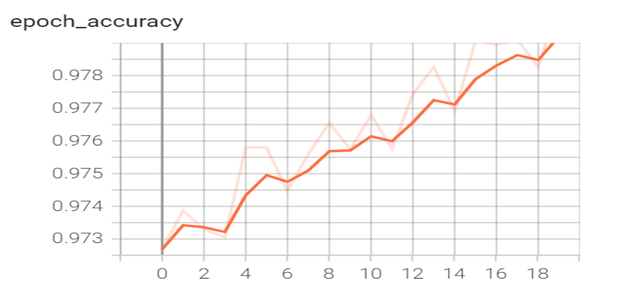
<center> 图7-37 准确率的变化</center>

图7-38 为采用Sequential API构建网络的计算图。
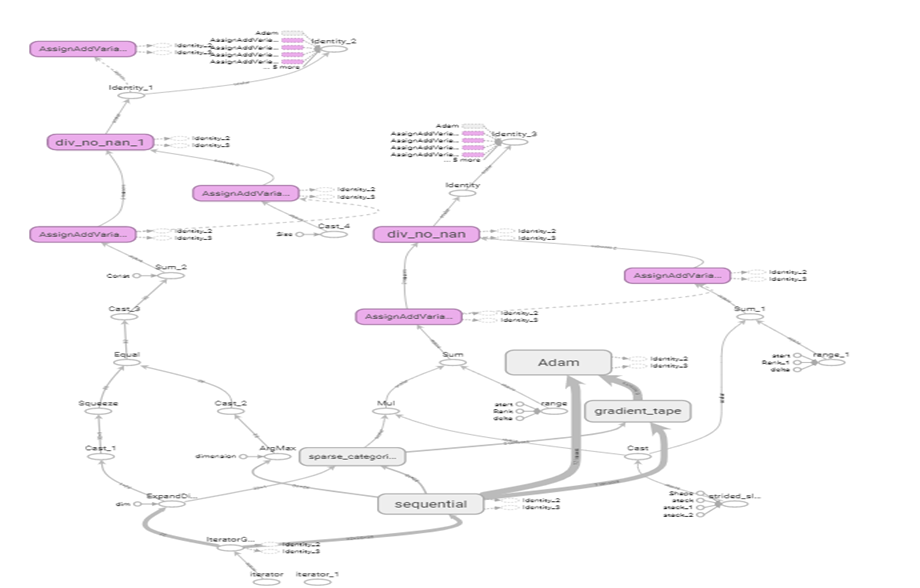
<center>7-38 可视化计算图</center>

### 7.7.5 使用Functional API搭建神经网络实例
	使用Functional API方式可搭建更复杂多样的网络结构图，可以实现多个输入、输出、隐含层与输入拼接、隐含层与隐含层拼接等

In [17]:
input = keras.layers.Input(shape=(28, 28)) 
x = keras.layers.Flatten()(input) 
hidden1 = keras.layers.Dense(300, activation="relu")(x)
hidden2 = keras.layers.Dense(100, activation="relu")(hidden1)
concat = keras.layers.concatenate([x, hidden2],axis=-1)
output = keras.layers.Dense(10, activation="softmax",name="output")(concat)
fu_model = keras.Model(inputs=[input], outputs=[output])

In [18]:
fu_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 300)          235500      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 100)          30100       dense_7[0][0]                    
______________________________________________________________________________________________

In [19]:
fu_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
fu_history = fu_model.fit(x_train,y_train,epochs=20,)

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6074 - accuracy: 0.7824
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3703 - accuracy: 0.8617
Epoch 3/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3273 - accuracy: 0.8776
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3022 - accuracy: 0.8876
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2821 - accuracy: 0.8935
Epoch 6/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2673 - accuracy: 0.9008
Epoch 7/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2506 - accuracy: 0.9063
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2426 - accuracy: 0.9078
Epoch 9/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2331 - accuracy: 0.9122
Epoch 10/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.221

In [20]:
test_loss, test_acc = fu_model.evaluate(x_test,  y_test, verbose=1)
print("测试集loss:{:.2f},测试集准确率：{:.2f}".format(test_loss,test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.3991 - accuracy: 0.8853
测试集loss:0.40,测试集准确率：0.89


### 7.7.6 使用Subclassing API构建神经网络实例
	前面介绍的Sequential API和Functional API都是声明式的，各类内置层直接拿来用即可。这种方式简单快捷：模型可以方便地进行保存、克隆和分享；模型架构可以方便地展示，便于分析；架构可以推断数据形状和类型，便于及时发现错误。调试也很容易，因为模型是层的静态图。但是，如果要满足一些更高要求，如包含循环、可变数据形状、条件分支等，使用这些方式就比较难了。对于这些情况，使用Subclassing API可以轻松实现。
	使用这种子类方式构建网络需要继承一个基类——tf.keras.Model，在构造器（即__init__（）函数）中创建需要的层，在call()函数中构建网络结构。构建思路如图7-39所示。
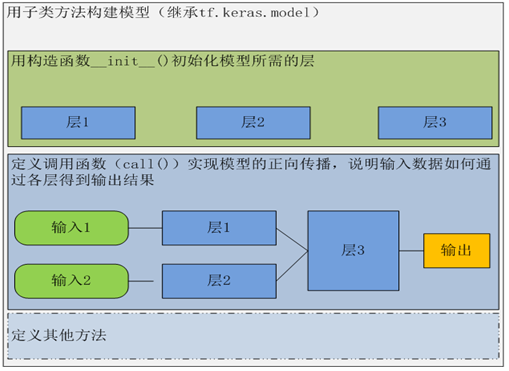

例如，通过创建一个CustomModel类的实例，可以创建与Functional API例子中的模型，同样可以进行编译、评估、预测。

In [21]:
class CustomModel(tf.keras.Model):

  def __init__(self, **kwargs):
    super(CustomModel, self).__init__(**kwargs)
    self.layer_1 = keras.layers.Flatten()
    self.layer_2 = keras.layers.Dense(300, "relu")
    self.layer_3 = keras.layers.Dense(100, "relu")
    self.layer_4 = keras.layers.Dense(10,'softmax')

  def call(self, inputs):
    x = self.layer_1(inputs)
    x = self.layer_2(x)
    x = self.layer_3(x)
    x = self.layer_4(x)
    return x
  #为使用summary时能显示tensor的shape
  def model01(self):
    x = keras.layers.Input(shape=(28, 28)) 
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

sub_model = CustomModel(name='mnist_model')

In [22]:
sub_model.model01().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## 训练模型

In [23]:
sub_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = sub_model.fit(x_train,y_train,epochs=20,)

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.5951 - accuracy: 0.7855
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3680 - accuracy: 0.8659
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3338 - accuracy: 0.8768
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3057 - accuracy: 0.8886
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2764 - accuracy: 0.8986
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2636 - accuracy: 0.8989
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2584 - accuracy: 0.9023
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2417 - accuracy: 0.9067
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2341 - accuracy: 0.9115
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.219

In [25]:
test_loss, test_acc = sub_model.evaluate(x_test,  y_test, verbose=1)
print("测试集loss:{:.2f},测试集准确率：{:.2f}".format(test_loss,test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.3663 - accuracy: 0.8963
测试集loss:0.37,测试集准确率：0.90


## 保存模型

In [26]:
se_model.save('my_model')

INFO:tensorflow:Assets written to: my_model\assets


## 恢复模型

In [27]:
se_model_new = keras.models.load_model('my_model')

In [28]:
se_model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [29]:
test_loss, test_acc = se_model_new.evaluate(x_test,  y_test, verbose=1)
print("测试集loss:{:.2f},测试集准确率：{:.2f}".format(test_loss,test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.6566 - accuracy: 0.8952
测试集loss:0.66,测试集准确率：0.90


## 训练时使用回调机制

In [31]:
se_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint = keras.callbacks.ModelCheckpoint("my_keras_model.h5")
history = se_model.fit(x_train, y_train, batch_size=32,epochs=20, callbacks=[checkpoint])
se_model_ck = keras.models.load_model("my_keras_model.h5") # 恢复模型

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0716 - accuracy: 0.9722
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0649 - accuracy: 0.9748
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0660 - accuracy: 0.9749
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0695 - accuracy: 0.9742
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0663 - accuracy: 0.9767
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0618 - accuracy: 0.9765
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0725 - accuracy: 0.9734
Epoch 8/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0622 - accuracy: 0.9759
Epoch 9/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0607 - accuracy: 0.9785
Epoch 10/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.058

In [32]:
se_model_ck.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [33]:
test_loss, test_acc = se_model_ck.evaluate(x_test,  y_test, verbose=1)
print("测试集loss:{:.2f},测试集准确率：{:.2f}".format(test_loss,test_acc))


313/313 [==============================] - 1s 2ms/step - loss: 0.8590 - accuracy: 0.8933
测试集loss:0.86,测试集准确率：0.89


## 使用TensorBoard进行可视化

In [34]:
def get_logdir():
    root_logdir = os.path.join(os.curdir, "my_logs")    
    run_id = time.strftime("run_%Y%m%d-%H%M%S")
    return os.path.join(root_logdir, run_id)

logdir = get_logdir() 

In [35]:
tensorboard_cb = keras.callbacks.TensorBoard(logdir)
history = se_model.fit(x_train, y_train, batch_size=64,epochs=20,callbacks=[tensorboard_cb])

Epoch 1/20
938/938 [==============================] - 5s 5ms/step - loss: 0.0291 - accuracy: 0.9893
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0289 - accuracy: 0.9894
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0316 - accuracy: 0.9877
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0359 - accuracy: 0.9865
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0362 - accuracy: 0.9863
Epoch 6/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0380 - accuracy: 0.9861
Epoch 7/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0341 - accuracy: 0.9870
Epoch 8/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0338 - accuracy: 0.9874
Epoch 9/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0354 - accuracy: 0.9873
Epoch 10/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0331 - accuracy: 0.9879

<font size=4 color=blue>在命令行（cmd）输入以下命令，如果是linux环境路径需要做一些修改  
tensorboard --logdir="C:\\Users\wumg\\jupyter-ipynb\\tensorflow2-book\\char-07\\my_logs" 
</font>

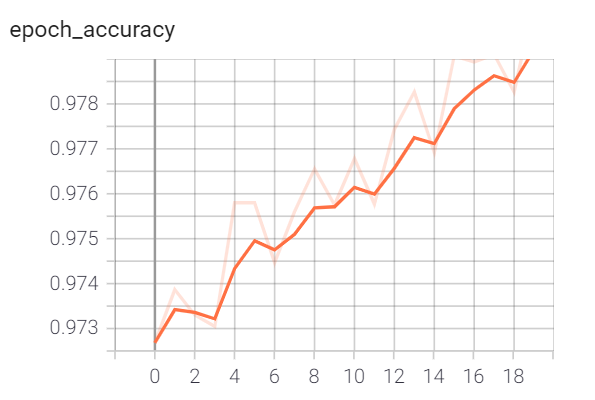

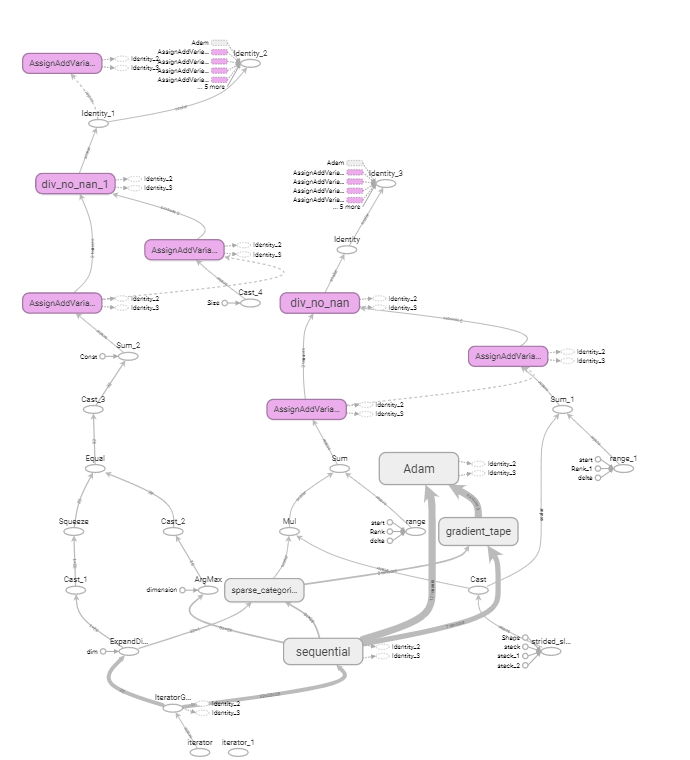